# Ocean surface Eddy Kinetic Energy trends

This Jupyter notebook shows how to compute the EKE trend maps reported in the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

#### Import Mann Kendall test:

In [2]:
from xarrayMannKendall import Mann_Kendall_test

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
from dask.distributed import Client

In [5]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:41089 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [6]:
dataset_EKE = xr.open_dataset('../datasets/EKE_timeseries.nc',chunks={'lat':10,'lon':10})

In [7]:
rho=1025 #kg/m^3

In [8]:
EKE_density = rho*dataset_EKE.EKE

In [9]:
EKE = EKE_density.sortby('time').sel(time=slice('1993','2020'))

In [10]:
# Print function used.
?Mann_Kendall_test

Init signature:
Mann_Kendall_test(
    DataArray,
    dim='time',
    alpha=0.01,
    MK_modified=False,
    method='linregress',
    coords_name=None,
)
Docstring:     
Compute linear trends and significance using Mann Kendall test.

Parameters
----------
DataArray : xarray.DataArray
    Dataset to analyse.
dim : str
    Coordiante name in which the linear trend will apply ('time').
alpha: float
    Significance level (default = 0.01)
MK_modified: Boolean
    Modified Mann-Kendall using Yue and Wang (2004) method.
    DOI: https://doi.org/10.1023/B:WARM.0000043140.61082.60
method: str
    Method for linear regresion: linregress (default) and theilslopes
coords_name: dict
    Coordinates name dict renames coordinates to 'lon','lat'. 
    Example:   
        coords_name={'xu_ocean':'lon','yu_ocean':'lat','t':time}
        
Example:

    # Time series length
    n=100
    time = np.arange(n)
    # Grid
    x = np.arange(4)
    y = np.arange(4)
    
    # Create dataarray
    data = np.ze

For more information in the Mann-Kendall method, please refer to: https://doi.org/10.1023/B:WARM.0000043140.61082.60

The reported trends use a modified Mann-Kendall method. A modified Mann-Kendall test is used to assess statistical significance of trends, while properly taking into account the autocorrelation in the time-series. The effective sample size for all the reported trends is always smaller than the actual sample size, due to autocorrelation of the time series. 

In [11]:
tke_trends = Mann_Kendall_test(EKE,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

Note that the following cell will take ~1 hour depending on the number of cores, as the Mann-Kendall method requirest to invert a matrix of shape (len(time),len(time)) for each grid point.

In [12]:
EKE_trends = tke_trends.compute()

In [13]:
EKE_trends.attrs['title'] = "Eddy Kinetic Energy"
EKE_trends.attrs['Description'] = """Eddy Kinetic Energy computed from AVISO+ altimetry. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
EKE_trends.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
EKE_trends.attrs['Author'] = "Josué Martínez-Moreno"
EKE_trends.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

EKE_trends.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

EKE_trends['trend'].attrs['units'] = r"$J m^{-3} day^{-1}$"
EKE_trends['trend'].attrs['name'] = 'trend'
EKE_trends['trend'].attrs['long_name'] = "Eddy Kinetic Energy trends"

EKE_trends['trend'].attrs['missing_value'] = np.nan
EKE_trends['trend'].attrs['valid_min'] = np.nanmin(EKE_trends['trend'])
EKE_trends['trend'].attrs['valid_max'] = np.nanmax(EKE_trends['trend'])
EKE_trends['trend'].attrs['valid_range'] = [np.nanmin(EKE_trends['trend']),np.nanmax(EKE_trends['trend'])]

######################################################

EKE_trends['signif'].attrs['units'] = ""
EKE_trends['signif'].attrs['name'] = 'signif'
EKE_trends['signif'].attrs['long_name'] = "Eddy Kinetic Energy trends significance"

EKE_trends['signif'].attrs['missing_value'] = np.nan
EKE_trends['signif'].attrs['valid_min'] = np.nanmin(EKE_trends['signif'])
EKE_trends['signif'].attrs['valid_max'] = np.nanmax(EKE_trends['signif'])
EKE_trends['signif'].attrs['valid_range'] = [np.nanmin(EKE_trends['signif']),np.nanmax(EKE_trends['signif'])]

######################################################

EKE_trends['p'].attrs['units'] = ""
EKE_trends['p'].attrs['name'] = 'p'
EKE_trends['p'].attrs['long_name'] = "Eddy Kinetic Energy trends p"

EKE_trends['p'].attrs['missing_value'] = np.nan
EKE_trends['p'].attrs['valid_min'] = np.nanmin(EKE_trends['p'])
EKE_trends['p'].attrs['valid_max'] = np.nanmax(EKE_trends['p'])
EKE_trends['p'].attrs['valid_range'] = [np.nanmin(EKE_trends['p']),np.nanmax(EKE_trends['p'])]

In [14]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in EKE_trends.data_vars}

EKE_trends.to_netcdf('../datasets/EKE_trends.nc', encoding=encoding)

In [15]:
EKE_trends

<xarray.Dataset>
Dimensions:    (x: 360, y: 180)
Coordinates:
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    trend      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    signif     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    p          (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    std_error  (y, x) float64 ...
Attributes:
    title:         Eddy Kinetic Energy
    Description:   Eddy Kinetic Energy computed from AVISO+ altimetry. Then t...
    Publication:   Dataset created for Martínez-Moreno, J. et. al. 2020: \n '...
    Author:        Josué Martínez-Moreno
    Contact:       josue.martinezmoreno@anu.edu.au
    Created date:  21/01/2021 11:22:29

In [16]:
trends = EKE_trends.trend*10*365 # Convert to trends per decade

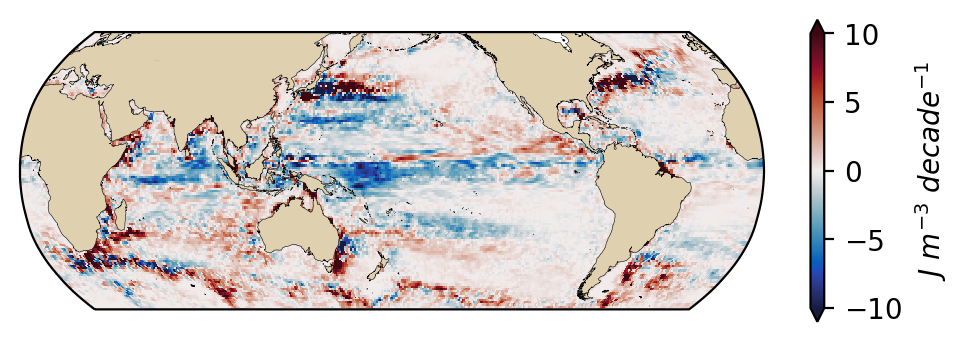

In [17]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$J\ m^{-3}\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-10, vmax=10,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)

# EKE decomposition trends

In [14]:
dataset_EKE = xr.open_dataset('../datasets/EKE_decomposition_timeseries.nc',chunks={'lat':10,'lon':10})

In [15]:
dataset_EKE

,Array,Chunk
Bytes,5.11 GB,7.89 MB
Shape,"(9861, 180, 360)","(9861, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.11 GB,7.89 MB
Shape,"(9861, 180, 360)","(9861, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float64,numpy.ndarray


### Mesoscale EKE trends

In [16]:
EKE_m_density = dataset_EKE.EKE_m

In [17]:
EKE_m = EKE_m_density.sortby('time').sel(time=slice('1993','2020'))


In [18]:
eke_m_trends = Mann_Kendall_test(EKE_m,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

In [19]:
EKE_m_trends = eke_m_trends.compute()

In [20]:
EKE_m_trends.attrs['title'] = "Mesoscale Eddy Kinetic Energy trends"
EKE_m_trends.attrs['Description'] = """Mesoscale Eddy Kinetic Energy computed from AVISO+ altimetry. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
EKE_m_trends.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
EKE_m_trends.attrs['Author'] = "Josué Martínez-Moreno"
EKE_m_trends.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

EKE_m_trends.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

EKE_m_trends['trend'].attrs['units'] = r"$J m^{-3} day^{-1}$"
EKE_m_trends['trend'].attrs['name'] = 'trend'
EKE_m_trends['trend'].attrs['long_name'] = "Mesoscale Eddy Kinetic Energy trends"

EKE_m_trends['trend'].attrs['missing_value'] = np.nan
EKE_m_trends['trend'].attrs['valid_min'] = np.nanmin(EKE_m_trends['trend'])
EKE_m_trends['trend'].attrs['valid_max'] = np.nanmax(EKE_m_trends['trend'])
EKE_m_trends['trend'].attrs['valid_range'] = [np.nanmin(EKE_m_trends['trend']),np.nanmax(EKE_m_trends['trend'])]

######################################################

EKE_m_trends['signif'].attrs['units'] = ""
EKE_m_trends['signif'].attrs['name'] = 'signif'
EKE_m_trends['signif'].attrs['long_name'] = "Mesoscale Eddy Kinetic Energy trends significance"

EKE_m_trends['signif'].attrs['missing_value'] = np.nan
EKE_m_trends['signif'].attrs['valid_min'] = np.nanmin(EKE_m_trends['signif'])
EKE_m_trends['signif'].attrs['valid_max'] = np.nanmax(EKE_m_trends['signif'])
EKE_m_trends['signif'].attrs['valid_range'] = [np.nanmin(EKE_m_trends['signif']),np.nanmax(EKE_m_trends['signif'])]

######################################################

EKE_m_trends['p'].attrs['units'] = ""
EKE_m_trends['p'].attrs['name'] = 'p'
EKE_m_trends['p'].attrs['long_name'] = "Mesoscale Eddy Kinetic Energy trends p"

EKE_m_trends['p'].attrs['missing_value'] = np.nan
EKE_m_trends['p'].attrs['valid_min'] = np.nanmin(EKE_m_trends['p'])
EKE_m_trends['p'].attrs['valid_max'] = np.nanmax(EKE_m_trends['p'])
EKE_m_trends['p'].attrs['valid_range'] = [np.nanmin(EKE_m_trends['p']),np.nanmax(EKE_m_trends['p'])]

In [21]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in EKE_m_trends.data_vars}

EKE_m_trends.to_netcdf('../datasets/mesoscale_EKE_trends.nc', encoding=encoding)

### Large-scale EKE trends

In [22]:
EKE_ls_density = dataset_EKE.EKE_ls

In [23]:
EKE_ls = EKE_ls_density.sortby('time').sel(time=slice('1993','2020'))

In [24]:
eke_ls_trends = Mann_Kendall_test(EKE_ls,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

In [25]:
EKE_ls_trends = eke_ls_trends.compute()

In [26]:
EKE_ls_trends.attrs['title'] = "Large-scale Eddy Kinetic Energy trends"
EKE_ls_trends.attrs['Description'] = """Mesoscale Eddy Kinetic Energy computed from AVISO+ altimetry. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
EKE_ls_trends.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
EKE_ls_trends.attrs['Author'] = "Josué Martínez-Moreno"
EKE_ls_trends.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

EKE_ls_trends.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

EKE_ls_trends['trend'].attrs['units'] = r"$J m^{-3} day^{-1}$"
EKE_ls_trends['trend'].attrs['name'] = 'trend'
EKE_ls_trends['trend'].attrs['long_name'] = "Large-scale Eddy Kinetic Energy trends"

EKE_ls_trends['trend'].attrs['missing_value'] = np.nan
EKE_ls_trends['trend'].attrs['valid_min'] = np.nanmin(EKE_ls_trends['trend'])
EKE_ls_trends['trend'].attrs['valid_max'] = np.nanmax(EKE_ls_trends['trend'])
EKE_ls_trends['trend'].attrs['valid_range'] = [np.nanmin(EKE_ls_trends['trend']),np.nanmax(EKE_ls_trends['trend'])]

######################################################

EKE_ls_trends['signif'].attrs['units'] = ""
EKE_ls_trends['signif'].attrs['name'] = 'signif'
EKE_ls_trends['signif'].attrs['long_name'] = "Large-scale Eddy Kinetic Energy trends significance"

EKE_ls_trends['signif'].attrs['missing_value'] = np.nan
EKE_ls_trends['signif'].attrs['valid_min'] = np.nanmin(EKE_ls_trends['signif'])
EKE_ls_trends['signif'].attrs['valid_max'] = np.nanmax(EKE_ls_trends['signif'])
EKE_ls_trends['signif'].attrs['valid_range'] = [np.nanmin(EKE_ls_trends['signif']),np.nanmax(EKE_ls_trends['signif'])]

######################################################

EKE_ls_trends['p'].attrs['units'] = ""
EKE_ls_trends['p'].attrs['name'] = 'p'
EKE_ls_trends['p'].attrs['long_name'] = "Large-scale Eddy Kinetic Energy trends p"

EKE_ls_trends['p'].attrs['missing_value'] = np.nan
EKE_ls_trends['p'].attrs['valid_min'] = np.nanmin(EKE_ls_trends['p'])
EKE_ls_trends['p'].attrs['valid_max'] = np.nanmax(EKE_ls_trends['p'])
EKE_ls_trends['p'].attrs['valid_range'] = [np.nanmin(EKE_ls_trends['p']),np.nanmax(EKE_ls_trends['p'])]

In [27]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in EKE_ls_trends.data_vars}

EKE_ls_trends.to_netcdf('../datasets/largescale_EKE_trends.nc', encoding=encoding)

## Plot trends

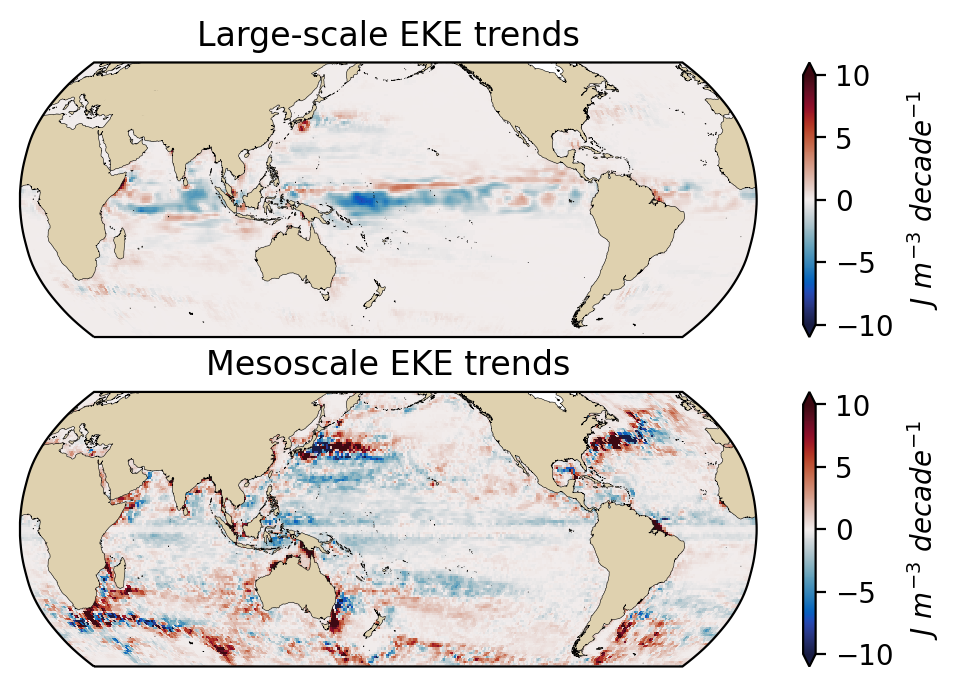

In [28]:
fig = plt.figure(figsize=(6,4), dpi=200)
ax = fig.add_subplot(2, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = (EKE_ls_trends.trend*10*365).plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$J\ m^{-3}\ decade^{-1}$"),
              cmap=cm.cm.balance,vmin=-10,vmax=10,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Large-scale EKE trends')
add_patches(ax)

ax = fig.add_subplot(2, 1, 2, projection = ccrs.Robinson(central_longitude=180))

im = (EKE_m_trends.trend*10*365).plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$J\ m^{-3}\ decade^{-1}$"),
              cmap=cm.cm.balance,vmin=-10,vmax=10,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Mesoscale EKE trends')
add_patches(ax)